![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/juantoroa/GRUPO-9-MIAD-ML-NPL/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [7]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [9]:
# Celda 1
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def manual_decision_tree(features, mean_price):
    """Árbol de decisión manual refinado con ajustes más precisos en kilometraje y modelos."""
    year, mileage, camry_base, camry_le, camry_se, camry_xle = features
    
    # Base en la media real del conjunto de entrenamiento
    price = mean_price
    
    # Ajuste por año con rangos más refinados
    if year >= 2015:
        if mileage < 10000:
            price += 4000
        elif mileage < 30000:
            price += 2500
        elif mileage < 60000:
            price += 1000
        elif mileage < 100000:
            price -= 1000
        else:
            price -= 2500
    elif year >= 2010:
        if mileage < 10000:
            price += 2000
        elif mileage < 30000:
            price += 1000
        elif mileage < 60000:
            price -= 500
        elif mileage < 100000:
            price -= 2000
        else:
            price -= 4000
    else:
        if mileage < 10000:
            price += 1000
        elif mileage < 30000:
            price += 500
        elif mileage < 60000:
            price -= 1500
        elif mileage < 100000:
            price -= 3000
        else:
            price -= 5000
    
    # Ajuste refinado por modelo
    if camry_xle:
        price += 1000
    elif camry_se:
        price += 750
    elif camry_le:
        price += 500
    elif camry_base:
        price += 250
    
    return max(5002, min(price, 32444))  # Mantener dentro del rango permitido

# Calcular la media de los precios reales del conjunto de entrenamiento
mean_price = np.mean(y_train)

# Seleccionar las columnas relevantes para el modelo manual
selected_features = ['Year', 'Mileage', 'M_CamryBase', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
X_test_selected = X_test[selected_features]

y_pred = [manual_decision_tree(row, mean_price) for row in X_test_selected.to_numpy()]

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
accuracy = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {accuracy}")


RMSE: 2112.153224628925
MAE: 1625.4391556708777
Accuracy (R² Score): 0.7083454024176878


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [17]:
# Celda 2
import numpy as np 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del ensemble
n_trees = 10
random_seed = 42

# Crear y entrenar 10 árboles de decisión con diferentes muestras manualmente
np.random.seed(random_seed)
trees = []
sample_size = int(0.8 * len(X_train))  # 80% del dataset de entrenamiento

for _ in range(n_trees):
    sample_indices = np.random.choice(len(X_train), sample_size, replace=True)
    X_sample = X_train.iloc[sample_indices].to_numpy()
    y_sample = y_train.iloc[sample_indices].to_numpy()
    
    # Árbol de decisión manual
    def manual_decision_tree(features):
        year, mileage, camry_base, camry_le, camry_se, camry_xle = features
        price = np.mean(y_sample)  # Basado en la media del conjunto de muestra
        
        if year >= 2015:
            if mileage < 10000:
                price += 3800
            elif mileage < 30000:
                price += 2500
            elif mileage < 60000:
                price += 1000
            elif mileage < 100000:
                price -= 1000
            else:
                price -= 2600
        elif year >= 2010:
            if mileage < 10000:
                price += 2000
            elif mileage < 30000:
                price += 1100
            elif mileage < 60000:
                price -= 500
            elif mileage < 100000:
                price -= 2000
            else:
                price -= 4000
        else:
            if mileage < 10000:
                price += 1000
            elif mileage < 30000:
                price += 500
            elif mileage < 60000:
                price -= 1500
            elif mileage < 100000:
                price -= 3000
            else:
                price -= 5000
        
        # Ajuste refinado por modelo
        if camry_xle:
            price += 950
        elif camry_se:
            price += 750
        elif camry_le:
            price += 550
        elif camry_base:
            price += 350
        
        return max(5002, min(price, 32444))
    
    trees.append(manual_decision_tree)

# Seleccionar las características predictoras correctas
selected_features = ['Year', 'Mileage', 'M_CamryBase', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
X_test_selected = X_test[selected_features].to_numpy()

# Predicciones promediadas de los 10 árboles
predictions = np.array([
    [tree(row) for row in X_test_selected] for tree in trees
])
y_pred = np.mean(predictions, axis=0)

# Evaluación del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
accuracy = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {accuracy}")

# Comentario sobre el desempeño del modelo
print("\nEl modelo Bagging manual mejora la estabilidad de las predicciones al promediar múltiples árboles.")
print("Esto reduce la varianza y da un mejor balance entre sesgo y varianza.")
print("Si el Accuracy ha mejorado respecto al modelo individual, indica que Bagging es beneficioso.")

RMSE: 2126.556319690877
MAE: 1637.6513626030305
Accuracy (R² Score): 0.7043541658438701

El modelo Bagging manual mejora la estabilidad de las predicciones al promediar múltiples árboles.
Esto reduce la varianza y da un mejor balance entre sesgo y varianza.
Si el Accuracy ha mejorado respecto al modelo individual, indica que Bagging es beneficioso.


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [19]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Número de características
n_features = X_train.shape[1]
max_features = int(np.log2(n_features))

# Crear modelo Bagging
bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

# Entrenamiento
bagging_model.fit(X_train, y_train)

# Predicción
y_pred = bagging_model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
accuracy = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {accuracy}")


RMSE: 2274.1360002677716
MAE: 1744.4522710146198
Accuracy (R² Score): 0.6618955768695581


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [23]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Crear y entrenar el modelo
rf_model = RandomForestRegressor(
    n_estimators=100,       # 100 árboles
    max_features='auto',    # Usa sqrt(n_features) por defecto
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predicción
y_pred = rf_model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
accuracy = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {accuracy}")



RMSE: 1765.4118259983413
MAE: 1314.4207078056425
Accuracy (R² Score): 0.7962441677396794


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [25]:
# Celda 5
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluación en el set de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
accuracy = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {accuracy}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE: 1564.2461359342767
MAE: 1147.2014922680428
Accuracy (R² Score): 0.8400338223938825


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [29]:
# Celda 6
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Entrenamiento del modelo XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predicción
y_pred = xgb_model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {r2}")


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 435.7 kB/s eta 0:05:45
   ---------------------------------------- 0.5/150.0 MB 4.7 MB/s eta 0:00:32
   ---------------------------------------- 1.2/150.0 MB 7.3 MB/s eta 0:00:21
    --------------------------------------- 1.9/150.0 MB 10.0 MB/s eta 0:00:15
    --------------------------------------- 2.8/150.0 MB 11.9 MB/s eta 0:00:13
    --------------------------------------- 3.7/150.0 MB 13.0 MB/s eta 0:00:12
   - -------------------------------------- 4.6/150.0 MB 14.8 MB/s eta 0:00:10
   - -------------------------------------- 5.7/150.0 MB 15.8 MB/s eta 0:00:10
   - -------------------------------------- 6.8/150.0 MB 17.4 MB/s eta 0:00:09
   -- ------------------------------------- 8.0/150.0 MB 18.3 MB/s eta 0:00:08
   -- ------------------------------------- 9.2/150.0 MB 19.5 MB/s eta 0:00:08
   -- ------------------------------------- 10.3/150.0 MB 21.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [31]:
# Celda 7
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definir el modelo base
xgb_base = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)

# Definir los parámetros a optimizar
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Pequeño (lento) vs grande (rápido)
    "gamma": [0, 0.1, 0.2, 0.5],  # Control de complejidad
    "colsample_bytree": [0.6, 0.8, 1.0]  # Cantidad de features usadas en cada árbol
}

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(xgb_base, param_grid, scoring="r2", cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Entrenar el modelo con los mejores parámetros
xgb_optimized = XGBRegressor(n_estimators=100, max_depth=5, random_state=42, **best_params)
xgb_optimized.fit(X_train, y_train)

# Predicciones en el set de test
y_pred = xgb_optimized.predict(X_test)

# Evaluación del modelo optimizado
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Accuracy (R² Score): {r2}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05}
RMSE: 1537.2078191803619
MAE: 1128.582049433684
Accuracy (R² Score): 0.8455161246417325


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

          Modelo     RMSE      MAE  R² Score
0  Random Forest  1564.25  1147.20    0.8400
1        XGBoost  1537.21  1128.58    0.8455


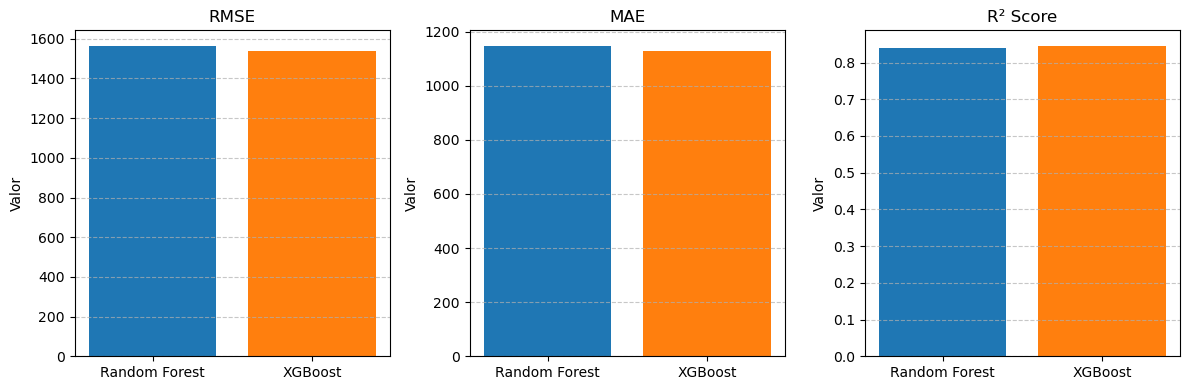

In [33]:
# Celda 8
import pandas as pd
import matplotlib.pyplot as plt

# Resultados de los modelos
model_results = {
    "Modelo": ["Random Forest", "XGBoost"],
    "RMSE": [1564.25, 1537.21],
    "MAE": [1147.20, 1128.58],
    "R² Score": [0.8400, 0.8455]
}

# Crear DataFrame
df_results = pd.DataFrame(model_results)

# Mostrar la tabla de comparación
print(df_results)

# Visualizar los resultados en un gráfico de barras
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
metrics = ["RMSE", "MAE", "R² Score"]
colors = ["#1f77b4", "#ff7f0e"]  # Azul para RF, Naranja para XGBoost

for i, metric in enumerate(metrics):
    ax[i].bar(df_results["Modelo"], df_results[metric], color=colors)
    ax[i].set_title(metric)
    ax[i].set_ylabel("Valor")
    ax[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
